In [9]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
import dill
from tqdm import tqdm
from datetime import date
import os, sys
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import Image, display, clear_output
from scipy import stats


from src.generate_data2 import pseudoVoigtSimulatorTorch, pseudoVoigtSimulator
from src.SERS_dataset import SERSDataset, IterDataset, SERSDatasetNPY


device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def plot_loss(epoch, epochs, loss, loss_kl, loss_recon, loss_test, loss_kl_test, loss_recon_test, z, x, recons, recons_mu, mu, logvar, tmp_img="plots_vae_temp2.png"):
    """ Plot the loss over time
    
    Args:
        loss (list): The loss over time

    Returns:
        None
    """
    x = x.to('cpu').detach().numpy()
    recons = recons.to('cpu').detach().numpy()
    recons_mu = recons_mu.to('cpu').detach().numpy()
    mu = mu.to('cpu').detach().numpy()
    logvar = logvar.to('cpu').detach().numpy()
    sigma = np.exp(0.5*logvar)
    z = z.to('cpu').detach().numpy()

    width = 3
    fig, axs = plt.subplots(3, width, figsize=(15, 15))

    # Figure title above all subplots
    fig.suptitle(f"Epoch {epoch} of {epochs}")

    # Plot loss
    axs[0, 0].plot(loss, label="Total loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].plot(loss_kl, label = "beta KL loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].plot(loss_recon, label = "Reconstruction loss")
    axs[0, 0].set_xlabel("Iteration")
    axs[0, 0].set_ylabel("Loss")

    axs[0, 0].set_title("Train loss")
    axs[0, 0].legend()

    # Plot test loss
    axs[0, 1].plot(loss_test, label="Total loss")
    axs[0, 1].set_title("Total loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Loss")

    axs[0, 1].plot(loss_kl_test, label = "beta KL loss")
    axs[0, 1].set_title("KL loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Loss")

    axs[0, 1].plot(loss_recon_test, label = "Reconstruction loss")
    axs[0, 1].set_xlabel("Iteration")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Test loss")

    axs[0, 1].legend()

    

    if z.shape[1] == 1: 
        colors = plt.cm.rainbow(np.linspace(0, 1, z.shape[0]))
        # randomize color order
        np.random.shuffle(colors)
        # Make spacing between points on y-axis
        y = np.linspace(0, 1, z.shape[0])
        # make horizontal lines 2*sigma above and below the mean
        axs[0,2].hlines(y, mu[:,0]-2*sigma[:,0], mu[:,0]+2*sigma[:,0], color=colors, alpha=0.4)
        axs[0,2].scatter(z[:,0], y, color=colors, s=10)
        # make y-axis taller
        # remove ticks on y axis
        axs[0,2].set_yticks([])

    else:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(mu)))
        axs[0,2].plot(z[:,0], z[:,1], 'o', alpha=0.5, c=colors)
        # get color from color map 
        # scatter plot with different colors
        # axs[0,2].scatter(z[:, 0], z[:, 1], c=colors, s = 3, alpha=0.9)

        # plot ellipses for each mu and sigma
        for i in range(len(mu)):
            mu_x = mu[i][0]
            mu_y = mu[i][1]
            sigma_x = sigma[i][0]
            sigma_y = sigma[i][1]
            # plot ellipse
            axs[0,2].scatter(mu_x, mu_y, color = colors[i], s=1, alpha=0.5)
            ellipse = matplotlib.patches.Ellipse((mu_x, mu_y), 2*sigma_x, 2*sigma_y, alpha=0.08, color=colors[i])
            axs[0,2].add_patch(ellipse)

        axs[0,2].set_xlabel("z1")
        axs[0,2].set_ylabel("z2")
        axs[0,2].set_title("Latent space")


    colors = plt.cm.rainbow(np.linspace(0, 1, len(mu[0])))
    for j in range(width):
        axs[1, j].plot(x[j].flatten(), label="Original")
        axs[1, j].plot(recons[j].flatten(), label="Reconstruction")
        axs[1, j].plot(recons_mu[j].flatten(), label="Reconstruction mu")
        axs[1, j].set_title("Reconstruction of SERS spectra")
        axs[1, j].set_xlabel("Wavenumber")
        axs[1, j].set_ylabel("Intensity (a.u.)")
        axs[1, j].legend()

        for i in range(len(mu[0]-1)):
            axs[2, j].axvline(mu[j][i], linestyle='--', alpha=0.5, color=colors[i])
            linsp = np.linspace(np.min(mu[j])-sigma[j][np.argmin(mu[j])]*3, np.max(mu[j])+sigma[j][np.argmax(mu[j])]*3, 100)
            axs[2, j].plot(linsp, stats.norm.pdf(linsp, mu[j][i], sigma[j][i]), label="Normal distribution", color=colors[i])
            axs[2, j].plot(z[j][i], 0, 'o', color=colors[i], alpha=0.5)
            axs[2, j].set_title("Latent space")
            # axs[2, j].set_xlabel("Wavenumber")
        

    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)


In [11]:
class Autoencoder(nn.Module):

    """ The autoencoder is a combination of the encoder and decoder
    
    Args:
        encoder (nn.Module): The encoder to use
        decoder (nn.Module): The decoder to use
        latent_dims (int): The number of latent dimensions to use
    """
    def __init__(self, latent_dims, decoder_type="alpha"):
        super(Autoencoder, self).__init__()

        self.encoder1 = nn.Linear(in_features=500, out_features=128).to(device)
        self.encoder2 = nn.ReLU().to(device)
        self.encoder_mu = nn.Linear(in_features=128, out_features=latent_dims).to(device)
        self.encoder_logvar = nn.Linear(in_features=128, out_features=latent_dims).to(device)


        self.decoder1 = nn.Linear(in_features=latent_dims, out_features=128).to(device)
        self.decoder2 = nn.ReLU().to(device)
        self.decoder3 = nn.Linear(in_features=128, out_features=500).to(device)

        self.kl = 0

        self.decoder_type = decoder_type


    def encode(self, x):
        h1 = self.encoder1(x)
        h2 = self.encoder2(h1)
        mu = self.encoder_mu(h2)
        logvar = self.encoder_logvar(h2)
        # torch rsample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std

        self.kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        
        return z, mu, logvar     
    


    def decode(self, z):
        # Decoder
        wavenumbers = 500
        ps = pseudoVoigtSimulatorTorch(wavenumbers)

        if self.decoder_type == "alpha":
            alpha = z[:,0]
            gamma = torch.full(alpha.shape, 20)
            eta = torch.full(alpha.shape, 0.5)
            c = torch.full(alpha.shape, 250)
        elif self.decoder_type == "c":
            c = z[:,0]
            gamma = torch.full(c.shape, 20)
            eta = torch.full(c.shape, 0.5)
            alpha = torch.full(c.shape, 5)


        batch_np = torch.zeros((c.shape[0], wavenumbers))
        for i in range(c.shape[0]):
            batch_np[i] = ps.generate_full_spectrum(c[i], gamma[i], eta[i], alpha[i], sigma=0)
            
        return batch_np

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        return self.decode(z)

In [12]:
def train(autoencoder, data, test_loader, optimizer="SGD", epochs=30, num_iterations_per_epoch = None, lr = 0.001, beta=1):
    """ Train the autoencoder on the data for a number of epochs
    
    Args:
        autoencoder (nn.Module): The autoencoder to train
        data (DataLoader): The data to train on
        epochs (int): The number of epochs to train for

    Returns:
        nn.Module: The trained autoencoder
    """

    # The optimizer is defined 
    if optimizer == 'adam':
        opt = torch.optim.Adam(autoencoder.parameters())
    else: 
        opt = torch.optim.SGD(autoencoder.parameters(), lr=10)

    # The loss function is defined
    loss_function = nn.MSELoss()

    # Lists to store the loss values
    train_loss = []
    test_loss = []
    train_loss_kl = []
    test_loss_kl = []
    train_loss_recon = []
    test_loss_recon = []


    x_test, y_test = next(iter(test_loader))


    # Loop through epochs 
    for epoch in range(epochs):
        batch_loss = []
        batch_loss_kl = []
        batch_loss_recon = []
        valid_loss = []
        valid_loss_kl = []
        valid_loss_recon = []        
        # Loop through batches of train data
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            recon_loss = loss_function(x_hat, x)
            # recon_loss = (x - x_hat).pow(2).mean(axis=1).mean()
            kl = autoencoder.kl * beta

            loss = recon_loss + kl
            loss.backward()
            opt.step()

            batch_loss.append(loss.item())
            batch_loss_kl.append(kl.item())
            batch_loss_recon.append(recon_loss.item())
            if num_iterations_per_epoch and i == num_iterations_per_epoch:
                break

        train_loss.append(np.mean(batch_loss))
        train_loss_kl.append(np.mean(batch_loss_kl))
        train_loss_recon.append(np.mean(batch_loss_recon))
        # print("train_loss: ", np.mean(batch_loss), "train_loss_KL: ", np.mean(batch_loss_kl), "train_loss_recon: ", np.mean(batch_loss_recon))

        
        # wandb.log({"train_loss": np.mean(batch_loss), "train_loss_KL": np.mean(batch_loss_kl), "train_loss_recon": np.mean(batch_loss_recon)})
 
        with torch.no_grad():
            autoencoder.eval()
            x, y = next(iter(test_loader))
            x = x.to(device)
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)
            x_hat_mu = autoencoder.decode(mu)   

            recon_loss = loss_function(x_hat, x)
            kl = autoencoder.kl * beta
            loss = recon_loss + kl


            z_test, mu_test, logvar_test = autoencoder.encode(x_test.to(device))
            x_hat_test = autoencoder.decode(z_test)
            x_hat_mu_test = autoencoder.decode(mu_test)


            valid_loss.append(loss.item())
            valid_loss_kl.append(kl.item())
            valid_loss_recon.append(recon_loss.item())
           

        test_loss.append(np.mean(valid_loss))
        test_loss_kl.append(np.mean(valid_loss_kl))
        test_loss_recon.append(np.mean(valid_loss_recon))

        if epoch % 9 == 0:
            plot_loss(epoch+1, epochs, train_loss, train_loss_kl, train_loss_recon, test_loss, test_loss_kl, test_loss_recon,
            z_test, x_test, x_hat_test, x_hat_mu_test, mu_test, logvar_test)
        # print("test_loss: ", np.mean(valid_loss), "test_loss_KL: ", np.mean(valid_loss_kl), "test_loss_recon: ", np.mean(valid_loss_recon))
        # wandb.log({"test_loss": np.mean(valid_loss), "test_loss_KL": np.mean(valid_loss_kl), "test_loss_recon": np.mean(valid_loss_recon)})

    return autoencoder, train_loss, test_loss

In [17]:
latent_dims = 1
num_batches_per_epoch = 10
learning_rate = 1e-2
beta = 0.01
optimizer = "adam"
batch_size = 100

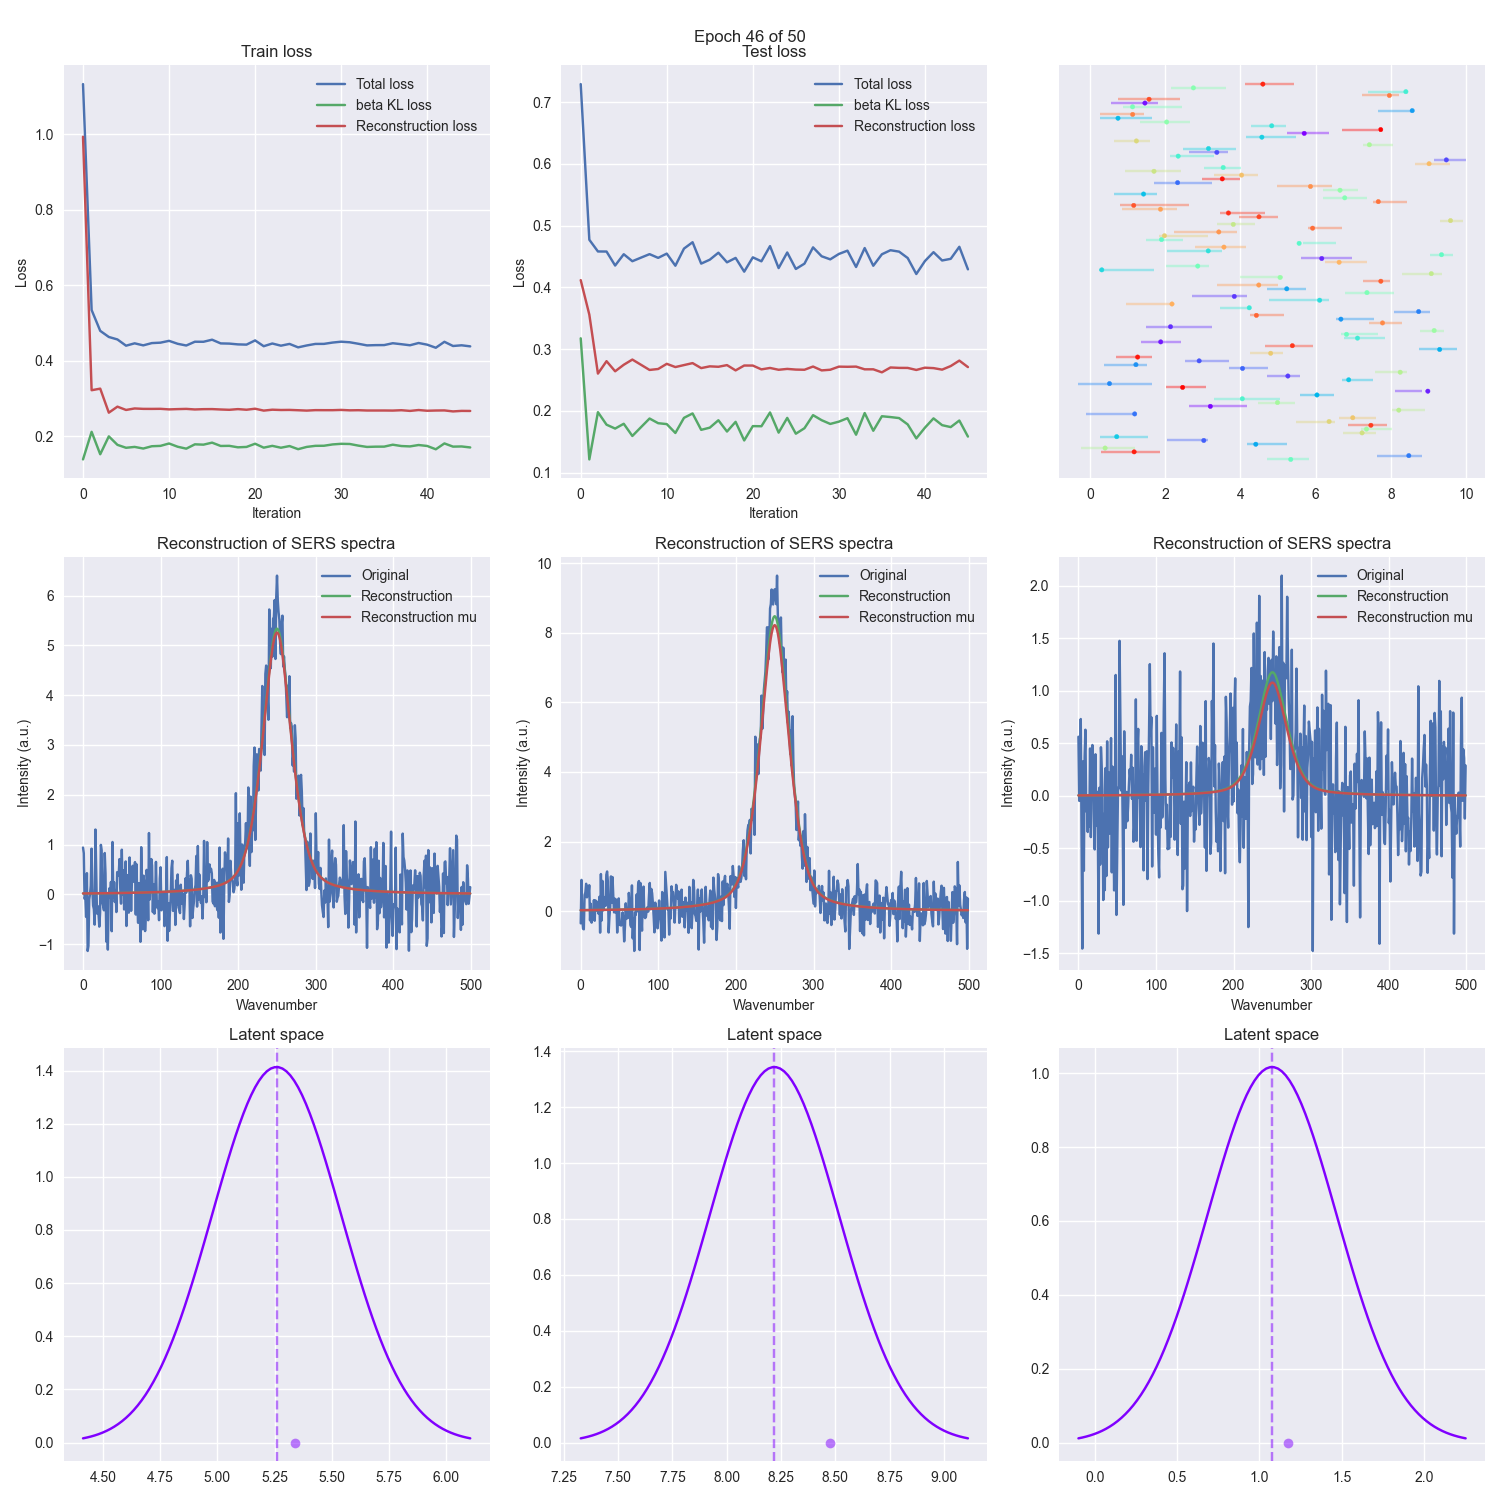

In [18]:
epochs = 50
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = Autoencoder(latent_dims, "alpha").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta)


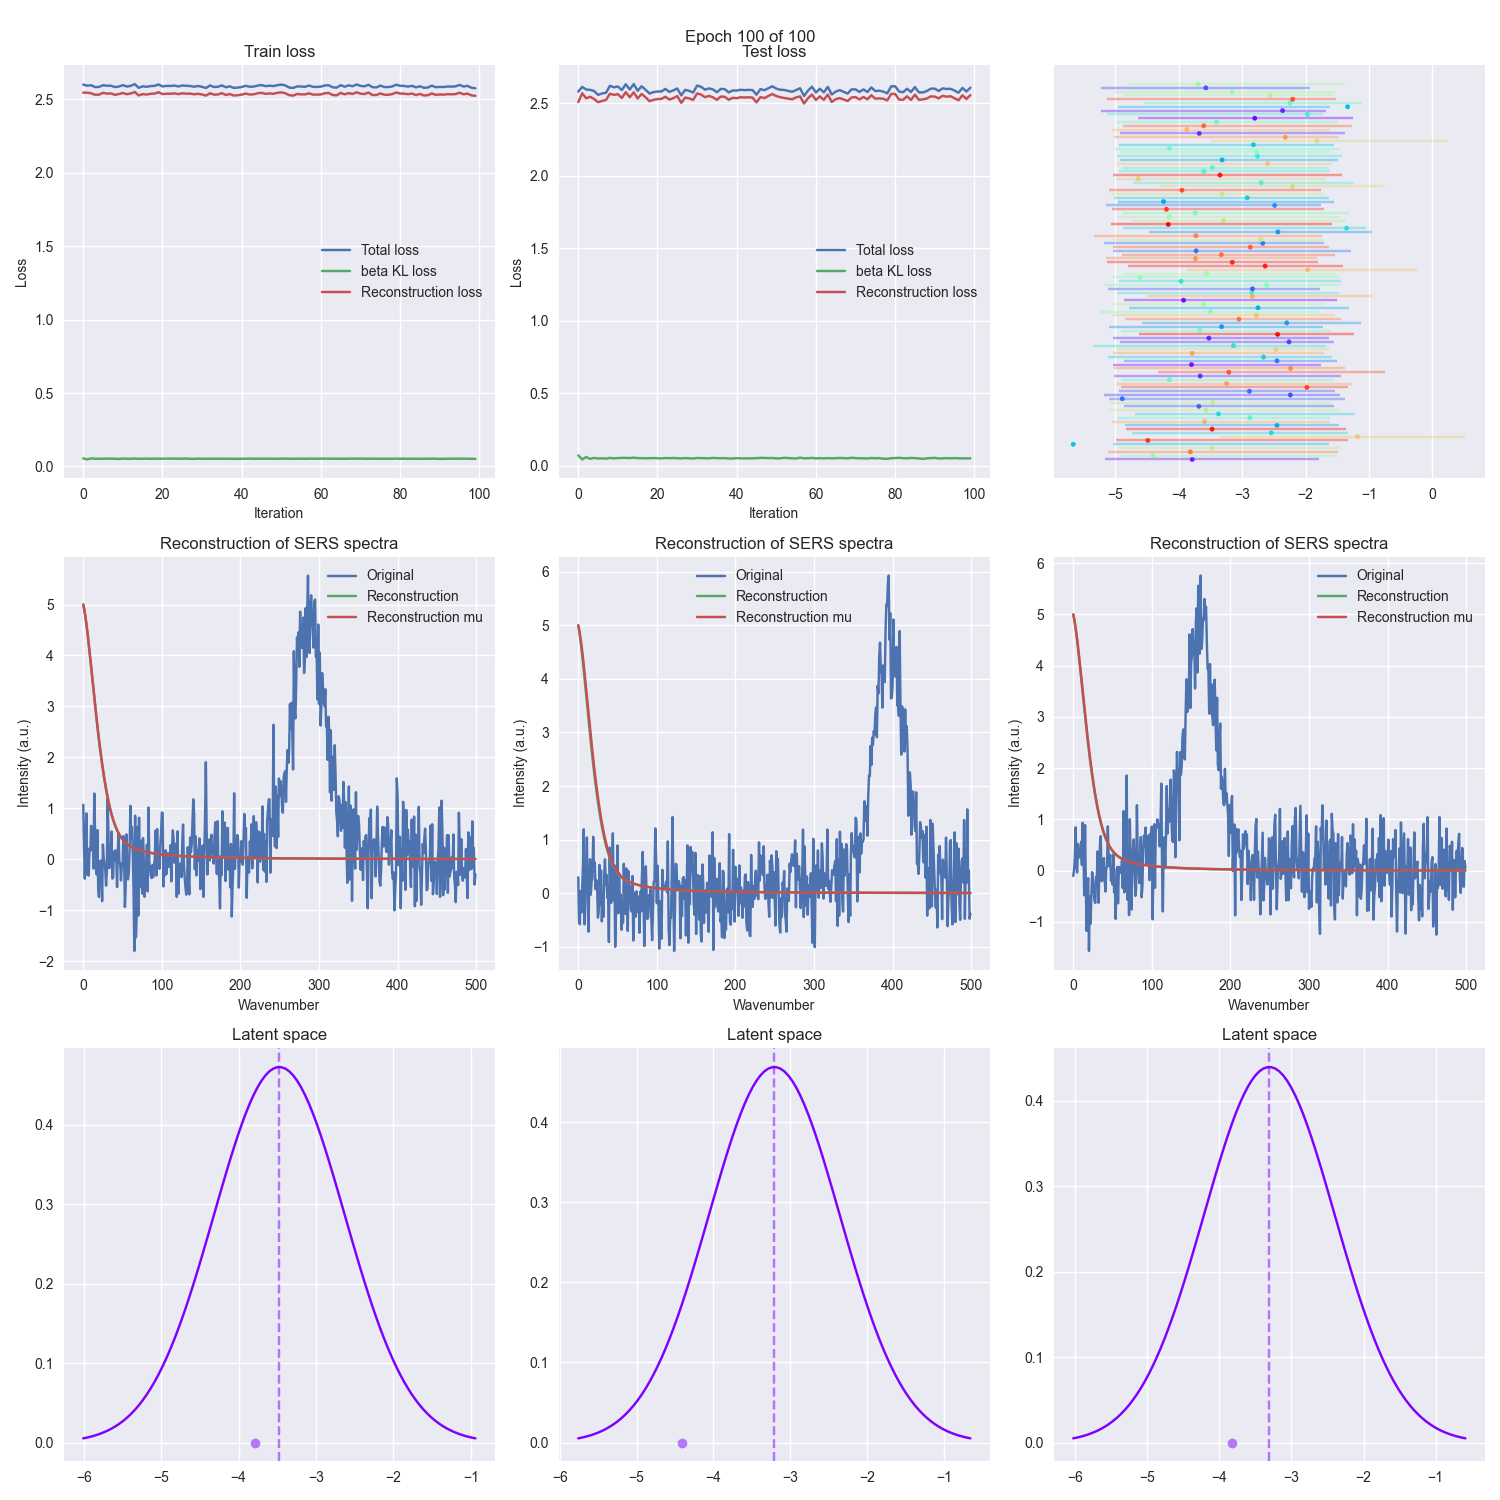

In [19]:
epochs = 100

ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50, 450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0.5)

dset_train = IterDataset(generator)
dset_test = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=batch_size, pin_memory=cuda)

autoencoder = Autoencoder(latent_dims, "c").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss, test_loss = train(autoencoder, train_loader, test_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta)


## Manual step through network ( for debugging )

torch.Size([100, 500])
z_shape: torch.Size([100, 1])
torch.Size([100]) torch.Size([100]) torch.Size([100]) torch.Size([100])
torch.Size([100, 500])
tensor(2.0544, grad_fn=<SelectBackward0>)
tensor(2.0544, grad_fn=<SelectBackward0>) tensor(20) tensor(0.5000) tensor(1)


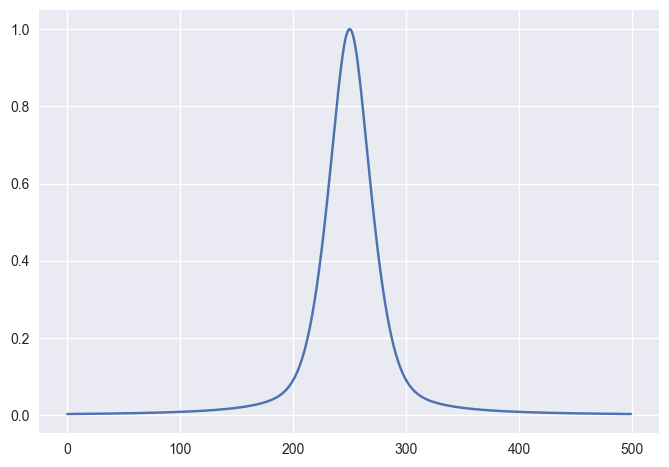

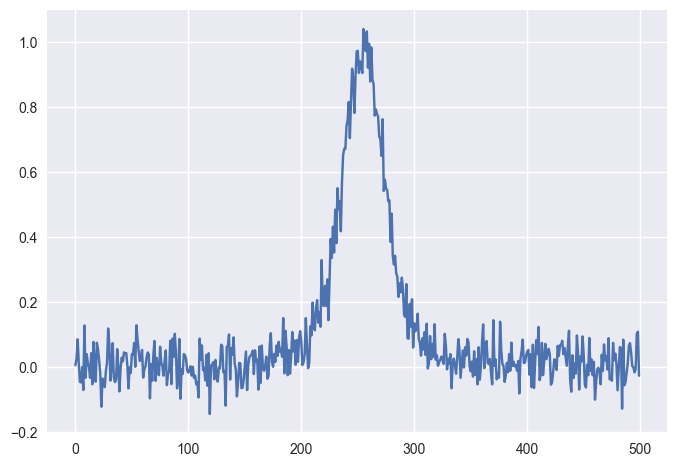

In [271]:
x , y = next(iter(train_loader))

print(x.shape)

# Encoder 
latent_dims = 1
autoencoder = Autoencoder(latent_dims).to(device) 
z, mu, logvar = autoencoder.encode(x)

print("z_shape:", z.shape)


# sigma = torch.exp(0.5*logvar)
# print(sigma[:,0].shape)
# # plot z on x axis with rainbow colors  
# colors = plt.cm.rainbow(np.linspace(0, 1, z.shape[0]))
# # randomize color order
# np.random.shuffle(colors)
# # Make spacing between points on y-axis
# y = np.linspace(0, 1, z.shape[0])
# # make horizontal lines 2*sigma above and below the mean
# plt.hlines(y, mu[:,0].detach().numpy()-2*sigma[:,0].detach().numpy(), mu[:,0].detach().numpy()+2*sigma[:,0].detach().numpy(), color=colors, alpha=0.4)
# plt.scatter(z[:,0].detach().numpy(), y, color=colors, s=10)
# # make y-axis taller
# # remove ticks on y axis
# plt.yticks([])
# plt.show()


# Decoder
wavenumbers = 500
ps = pseudoVoigtSimulatorTorch(wavenumbers)
c = z[:,0]


# numpy array of 0.5 with shape of c
gamma = torch.full(c.shape, 20)
eta = torch.full(c.shape, 0.5)
# c = torch.full(c.shape, 250)
alpha = torch.full(c.shape, 1)
print(c.shape, alpha.shape, gamma.shape, eta.shape)

batch_np = torch.zeros((c.shape[0], wavenumbers))
for i in range(c.shape[0]):
    # batch.append(ps.generate_full_spectrum(alpha[i], c[i], gamma[i], eta[i]))
    # print(c[i], alpha[i], gamma[i], eta[i])
    # print(len(c[i]), len(alpha[i]), len(gamma[i]), len(eta[i]))
    batch_np[i] = ps.generate_full_spectrum(c[i], gamma[i], eta[i], alpha[i], noise_to_signal_ratio=0)
print(batch_np.shape)
i=0
print(c[i])
s = ps.generate_full_spectrum(torch.tensor(250), gamma[i], eta[i], alpha[i], noise_to_signal_ratio=0)
print(c[i], gamma[i], eta[i], alpha[i])
plt.plot(s.detach().numpy())
plt.show()

plt.plot(x[0].detach().numpy())
plt.show()

In [72]:
x , y = next(iter(train_loader))

print(x.shape)

# Encoder 
latent_dims = 1
autoencoder = Autoencoder(latent_dims).to(device) 
z, mu, logvar = autoencoder.encode(x)

# Decoder
wavenumbers = 500
ps = pseudoVoigtSimulatorTorch(wavenumbers)
# alpha = z[:,0]
c = z[:,0]

# numpy array of 0.5 with shape of c
gamma = torch.full(alpha.shape, 20)
eta = torch.full(alpha.shape, 0.5)
# c = torch.full(alpha.shape, 250)
alpha = torch.full(c.shape, 1)

print(alpha.shape, c.shape, gamma.shape, eta.shape)

# print(c)

batch_np = torch.zeros((c.shape[0], wavenumbers))
for i in range(c.shape[0]):
    print(c[i].shape, alpha[i], gamma[i], eta[i])

    print(1 if c[i].shape else 2)
    batch_np[i] = ps.generate_full_spectrum(c[i], gamma[i], eta[i], alpha[i], sigma=0)

print(batch_np.shape)   

# loss_function = nn.MSELoss()


# opt_x = torch.arange(-500, 500, 1)

# opt_y = torch.zeros(opt_x.shape)

# for i in range(opt_x.shape[0]):
#     opt_y[i] = ps.generate_full_spectrum(opt_x[i], gamma[0], eta[0], alpha[0], sigma=0)
# s= ps.generate_full_spectrum(torch.tensor(0), gamma[0], eta[0], alpha[0], sigma=0)

# # Loss between s and x[0]
# print(loss_function(s, x[0]))


# plt.plot(batch_np[0].detach().numpy())
# plt.plot(x[0].detach().numpy())
# plt.plot(s.detach().numpy())
# plt.show()

torch.Size([100, 500])
torch.Size([100]) torch.Size([100]) torch.Size([100]) torch.Size([100])
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torch.Size([]) tensor(1) tensor(20) tensor(0.5000)
2
torc

Checking what happens to the loss function 

torch.Size([1]) torch.Size([1]) torch.Size([1]) torch.Size([1])
torch.Size([2000, 1])


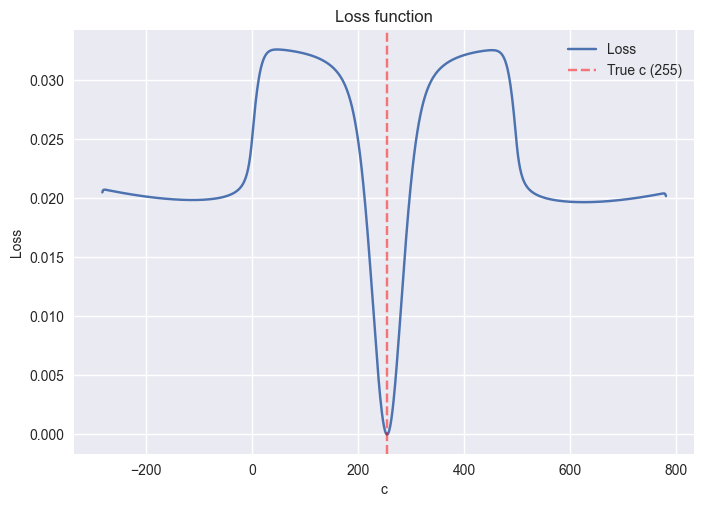

TypeError: pseudoVoigtSimulatorTorch.generate_full_spectrum() got an unexpected keyword argument 'simga'

In [ ]:
wavenumbers = 500
ps = pseudoVoigtSimulatorTorch(wavenumbers)

true_c = torch.tensor([255])
gamma = torch.tensor([20])
eta = torch.tensor([0.5])
alpha = torch.tensor([0.5])

print(alpha.shape, true_c.shape, gamma.shape, eta.shape)

x = ps.generate_full_spectrum(true_c, gamma, eta, alpha, sigma=0)


loss_function = nn.MSELoss()


opt_x = torch.arange(-1000, 1000, 1)
# reshape so it becomes a column vector
opt_x = opt_x.reshape(-1,1)


opt_y = torch.zeros(opt_x.shape)
for i in range(opt_x.shape[0]):
    s = ps.generate_full_spectrum(opt_x[i], gamma, eta, alpha, sigma=0)

    # Loss between s and x[0]
    opt_y[i] = loss_function(s, x)


print(opt_y.shape)
plt.plot(opt_x.detach().numpy(),opt_y.detach().numpy())
# title 
plt.title("Loss function")
# x-axis name
plt.xlabel("c")
# y-axis name
plt.ylabel("Loss")

# plot horizontal line in 255 
plt.axvline(x=255, color='r', linestyle='--', alpha=0.5)
# give line a label
plt.legend(['Loss', f'True c ({true_c.item()})'])
plt.show()


s = ps.generate_full_spectrum(torch.tensor(-1000), gamma[0], eta[0], alpha[0], simga=0)

# Loss between s and x[0]
print(loss_function(s, x))

